In [6]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import tensorflow as tf
import seaborn as sns
#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
Heart_attack_df = pd.read_csv('Resources/cleaned_heart_disease_dataset.csv')
Heart_attack_df.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,risk
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
# Rename target column to classify risk of suffering a heart attack and sex column

Heart_attack_df = Heart_attack_df.rename(columns={'target': 'risk',
                        'sex': 'gender'})
Heart_attack_df.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,risk
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
# Confirm all columns are interger datatypes

Heart_attack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1888 non-null   int64  
 1   gender    1888 non-null   int64  
 2   cp        1888 non-null   int64  
 3   trestbps  1888 non-null   int64  
 4   chol      1888 non-null   int64  
 5   fbs       1888 non-null   int64  
 6   restecg   1888 non-null   int64  
 7   thalachh  1888 non-null   int64  
 8   exang     1888 non-null   int64  
 9   oldpeak   1888 non-null   float64
 10  slope     1888 non-null   int64  
 11  ca        1888 non-null   int64  
 12  thal      1888 non-null   int64  
 13  risk      1888 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 206.6 KB


In [9]:
# Unique values per column

Heart_attack_df.nunique()

age          41
gender        2
cp            5
trestbps     50
chol        152
fbs           2
restecg       3
thalachh     92
exang         2
oldpeak      40
slope         4
ca            5
thal          6
risk          2
dtype: int64

In [10]:
# Age column displayed in descending order
## 50s is the dominate age group in dataset

ages = Heart_attack_df['age'].value_counts().sort_values(ascending=False)

## Explanatory  Research Questions

## Which features are the most indicative of an individual having heart disease?

C:\Users\bavth\AppData\Local\Temp\ipykernel_27964\286499072.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")


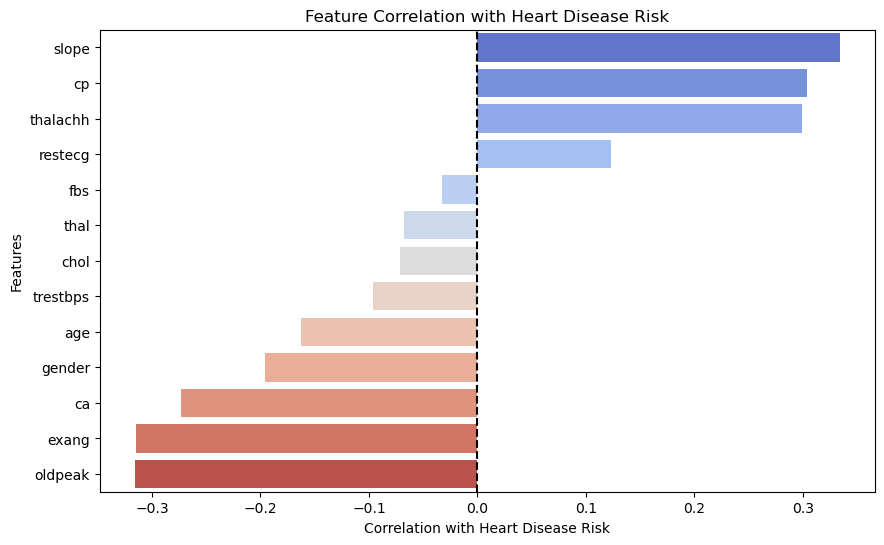

In [30]:
#Creating a barplot to see which features are the most indicative of an individual having heart disease

# Getting the correlation of the features with the target variable 
corr_with_target = Heart_attack_df.corr()["risk"].drop("risk") 

# Sort correlations in descending order
corr_with_target = corr_with_target.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")
plt.xlabel("Correlation with Heart Disease Risk")
plt.ylabel("Features")
plt.title("Feature Correlation with Heart Disease Risk")
plt.axvline(0, color="black", linestyle="--")  
plt.savefig("Graphs/feature_correlation_with_risk.png")  
plt.show()

This chart shows how different features correlate with the likelihood of heart disease:

Strong Positive Indicators (Higher values increase risk):

Slope: ST segment changes in ECG.
Chest Pain Type (cp): Certain chest pain types indicate higher risk.
Max Heart Rate (thalachh): Higher values correlate with increased risk.
Strong Negative Indicators (Higher values decrease risk):

ST Depression (oldpeak): Lower values indicate higher risk.
Exercise-induced Angina (exang): Presence of angina suggests greater risk.
Number of Major Vessels (ca): More visible vessels mean lower risk.
Weaker Indicators: Age, gender, resting blood pressure, and cholesterol show weaker correlations with heart disease risk.

Chest pain type, ST depression, and max heart rate are the strongest predictors of heart disease risk.

## What is the distribution of heart disease across different age groups?

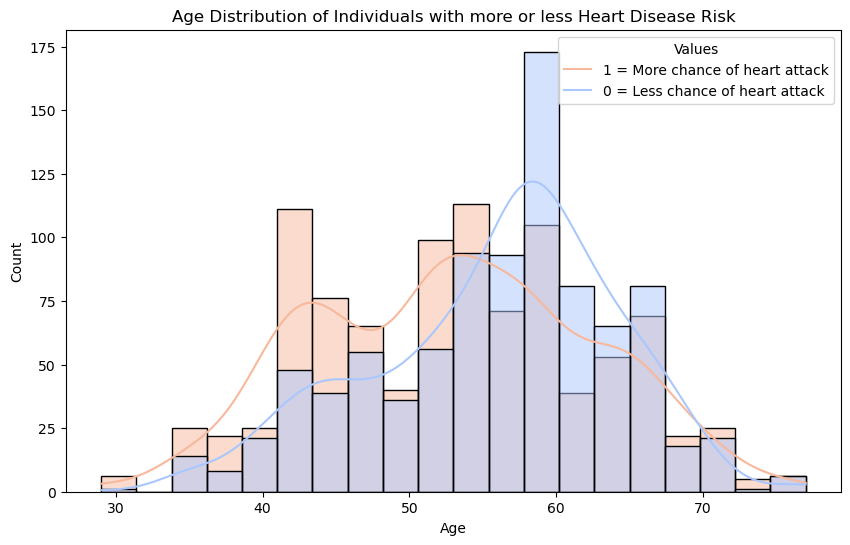

In [33]:
#Creating a histrogram plot to showcase the distribution of heart disease across different age groups

plt.figure(figsize=(10, 6))
sns.histplot(Heart_attack_df, x="age", hue="risk", kde=True, bins=20, palette="coolwarm")

#labels and title
plt.title("Age Distribution of Individuals with more or less Heart Disease Risk")
plt.xlabel("Age")
plt.ylabel("Count")
# editing the legend
legend_labels = ["1 = More chance of heart attack", "0 = Less chance of heart attack"]
plt.legend(legend_labels, title="Values", loc="upper right")
plt.savefig("Graphs/Age Distribution of Individuals with more or less Heart Disease Risk.png")  

This histogram visualizes the distribution of individuals with and without heart disease across different age groups.

Heart disease is more prevalent among individuals aged 40 to 60, as indicated by the higher density of the orange bars in this range.Individuals in their 50s and early 60s appear to have a higher number of cases without heart disease, but heart disease cases are still present.The presence of heart disease declines after the mid-60s, possibly due to fewer older individuals in the dataset.

This graph suggests that middle-aged individuals (40–60 years old) are at a higher risk of developing heart disease compared to younger and older populations

## How does oldpeak (ST depression) affect the possibility of a heart attack?

C:\Users\bavth\AppData\Local\Temp\ipykernel_27964\2394485448.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="risk", y="oldpeak", data=df, palette="coolwarm")


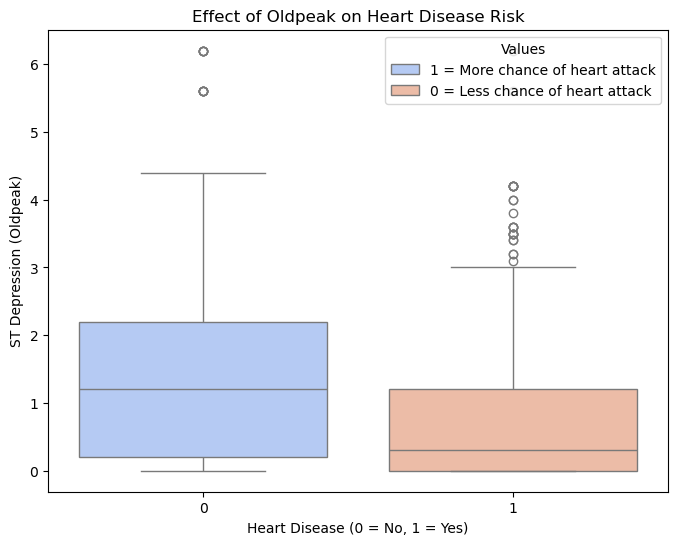

In [34]:
# Creating a boxplot to compare oldpeak values for individuals with and without heart disease.
plt.figure(figsize=(8, 6))
sns.boxplot(x="risk", y="oldpeak", data=df, palette="coolwarm")
plt.title("Effect of Oldpeak on Heart Disease Risk")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("ST Depression (Oldpeak)")
#Creating legend 
plt.legend(legend_labels, title="Values", loc="upper right")
plt.savefig("Graphs/Effect of Oldpeak on Heart Disease Ris.png")  

This box plot compares ST depression levels (Oldpeak) between individuals with and without heart disease.Individuals without heart disease (0 - blue) tend to have a higher median Oldpeak value compared to those with heart disease.The spread (IQR) of Oldpeak values is larger in the group without heart disease, suggesting more variation in ST depression levels.Those with heart disease (1 - orange) generally have lower Oldpeak values, with a median closer to zero.There are more outliers in the heart disease group, indicating that some individuals with heart disease still have high ST depression values.A higher Oldpeak does not necessarily indicate a higher risk of heart disease. In fact, individuals with lower Oldpeak values seem to have a higher heart disease risk in this dataset.This suggests that ST depression alone may not be a strong predictor of heart disease and should be analyzed alongside other risk factors

##  Are there threshold values for features like resting heart pressure or cholesterol levels that indicate a higher chance of having heart disease?

C:\Users\bavth\AppData\Local\Temp\ipykernel_27964\1265021859.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="risk", y="trestbps", data=df, palette="coolwarm")


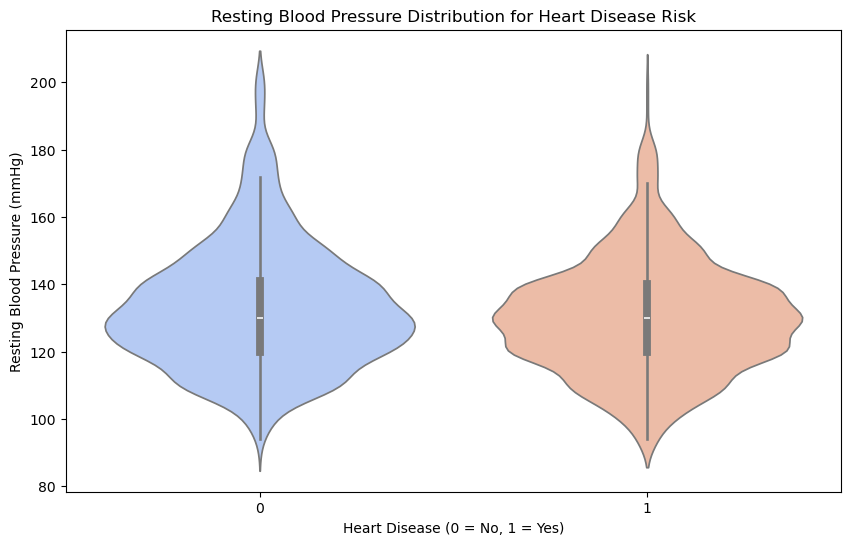

C:\Users\bavth\AppData\Local\Temp\ipykernel_27964\1265021859.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="risk", y="chol", data=df, palette="coolwarm")


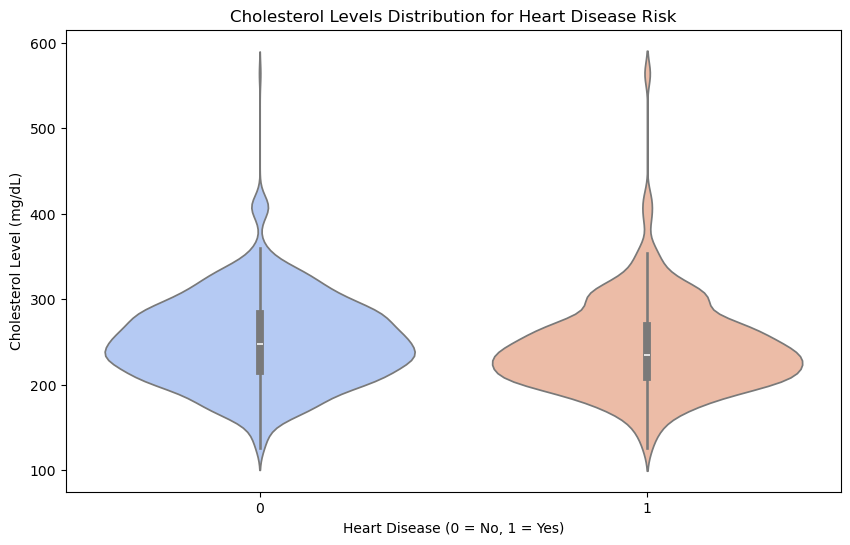

In [36]:
# Creating violin plots to show the distribution of resting blood pressure and cholesterol

# Resting Blood Pressure vs. Heart Disease
plt.figure(figsize=(10, 6))
sns.violinplot(x="risk", y="trestbps", data=df, palette="coolwarm")
plt.title("Resting Blood Pressure Distribution for Heart Disease Risk")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Resting Blood Pressure (mmHg)")

plt.savefig("Graphs/Resting Blood Pressure Distribution for Heart Disease Risk.png")
plt.show()

# Cholesterol vs. Heart Disease
plt.figure(figsize=(10, 6))
sns.violinplot(x="risk", y="chol", data=df, palette="coolwarm")
plt.title("Cholesterol Levels Distribution for Heart Disease Risk")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Cholesterol Level (mg/dL)")

plt.savefig("Graphs/Cholesterol Levels Distribution for Heart Disease Risk.png")
plt.show()

# Resting Blood Pressure Distribution for Heart Disease Risk
The distribution of resting blood pressure appears similar for both individuals with low and high and heart disease risk.The spread of blood pressure values is slightly higher for individuals without heart disease.The median and interquartile range are nearly overlapping, suggesting resting blood pressure alone may not be a strong distinguishing factor for heart disease.

# Cholesterol Levels Distribution for Heart Disease Risk
Cholesterol levels exhibit a wider range for individuals without heart disease.The distribution for individuals with high risk of heart disease is slightly more concentrated around lower cholesterol levels.This suggests that cholesterol levels alone may not be a definitive predictor but still play a role in heart disease risk.

Text(0, 0.5, 'Number of Participants')

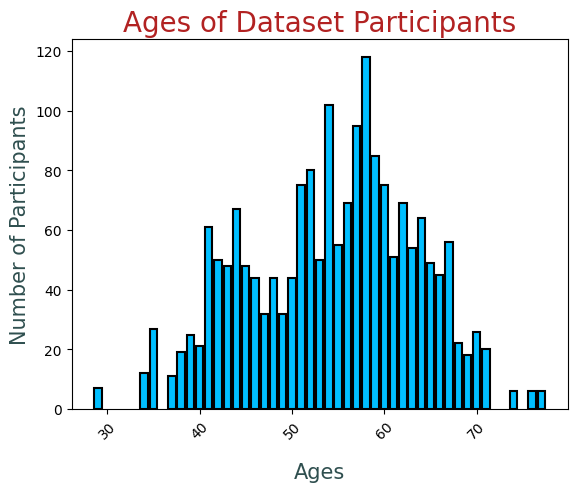

In [6]:
# Bar chart visualization of dataset's age column
# plotly

plt.bar(ages.index, ages, color="deepskyblue", align="center", edgecolor='k', linewidth=1.5)
plt.xticks(rotation=45, color="k")
plt.yticks(color="k")
plt.title("Ages of Dataset Participants", fontsize=20, color='firebrick')
plt.xlabel('Ages', fontsize=15, color='darkslategray', labelpad=15)
plt.ylabel('Number of Participants', fontsize=15, color='darkslategray')

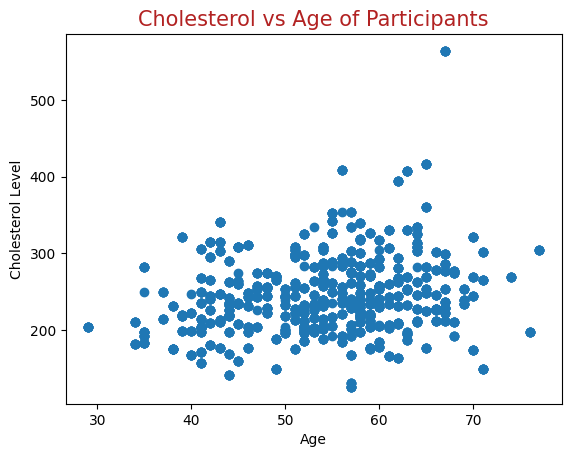

In [24]:
# Scatterplot to check cholesterol column for outliers
# plotly

## Data appears appropriately grouped




# correlation_line = round(st.pearsonr(df["chol"], df["age"])[0],2)
# model = st.linregress(df["chol"], df["age"])

# # model just has two points, start and end, 0 and 1, NOT SAME AS SCIPY
# values = df["chol"]*model[0]+model[1]
# plt.plot(df["age"], values, color="red")






plt.scatter(df["age"], df["chol"])
plt.xlabel("Age")
plt.ylabel("Cholesterol Level")
plt.title("Cholesterol vs Age of Participants", fontsize=15, color='firebrick')
plt.show()

In [8]:
# Gender column value count
# 1 = Male, 0 = Female

## Possible bias
## Dataset is heavily weighed towards males

genders = df['gender'].value_counts()
genders

,count
gender,
1,1300
0,588


<Axes: title={'center': 'Gender of Dataset Participants'}, xlabel='1 = Male           0 = Female', ylabel=' '>

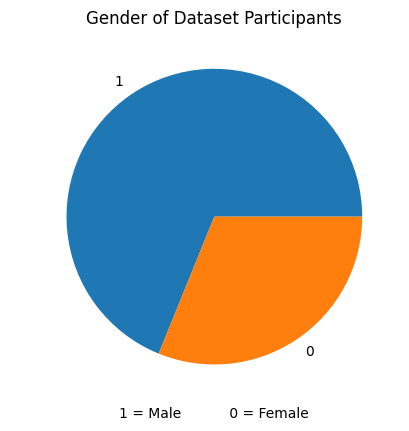

In [9]:
# Pie chart visualization of gender column's unbalanced data
# pandas chart

chart = genders.plot(kind="pie", title="Gender of Dataset Participants")
chart.set_xlabel("1 = Male           0 = Female")
chart.set_ylabel(" ")
chart

In [10]:
# Fasting blood sugar (fbs) > 120 mg/dl
# 1 = true, 0 = false.

## Possible bias
## Large majority of dataset have fbs above 120 mg/dl

fbs = df['fbs'].value_counts()
fbs

,count
fbs,
0,1608
1,280


<Axes: title={'center': 'Fast Blood Sugar > 120 mg/dl'}, xlabel='1 = Above 120           0 = Below 120', ylabel=' '>

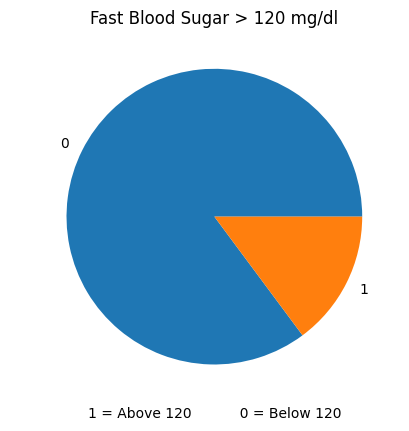

In [11]:
# Pie chart visualization of fbs column's unbalanced data
# pandas chart

chart = fbs.plot(kind="pie", title="Fast Blood Sugar > 120 mg/dl")
chart.set_xlabel("1 = Above 120           0 = Below 120")
chart.set_ylabel(" ")
chart

In [12]:
# Risk of a heart attack
# 1 = risk, 0 = not at risk
## Near even split in data. Good to use as target column

risk = df['risk'].value_counts()

<Axes: title={'center': 'Likelyhood of Heart Attack'}, xlabel='1 = At Risk           0 = Not Likely', ylabel='Number of Participants'>

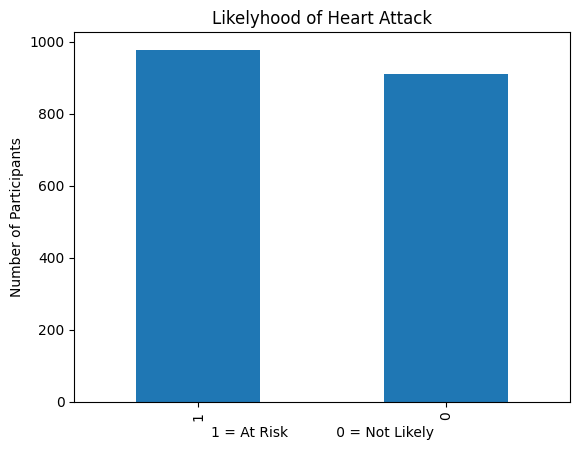

In [22]:
# Bar chart visualization of risk column's balanced data
# pandas chart

chart = risk.plot(kind="bar", title="Likelyhood of Heart Attack")
chart.set_xlabel("1 = At Risk           0 = Not Likely")
chart.set_ylabel("Number of Participants")
chart


In [25]:
# Split our preprocessed data into our features and target arrays
y = df['risk'].values
X = df.drop(['risk'], axis='columns').values


# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()
input_layers = len(X_train[0])

## 2/3 rule of number of columns(features) it's reshaped into
hidden_layer_1 = 120
hidden_layer_2 = 60
hidden_layer_3 = 30
hidden_layer_4 = 15
hidden_layer_5 = 7

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_1, activation="relu", input_dim=input_layers))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_3, activation="relu"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_3, activation="relu"))

# Fifth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_3, activation="relu"))

# Output layer - sigmoid with used with binary data
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 120)                 │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 60)                  │           7,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,661 (49.46 KB)

 Trainable params: 12,661 (49.46 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6881 - loss: 0.6288
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8269 - loss: 0.3936
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8814 - loss: 0.2972
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9224 - loss: 0.2240
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9454 - loss: 0.1716
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9587 - loss: 0.1292
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9612 - loss: 0.1179
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9739 - loss: 0.0808
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9768 - loss: 0.0654
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9839 - loss: 0.0525
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9823 - loss: 0.0513
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

In [19]:
# Evaluate the model using training data
model_loss, model_accuracy = nn.evaluate(X_train_scaled,y_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

45/45 - 0s - 6ms/step - accuracy: 1.0000 - loss: 2.0372e-05
Loss: 2.0371860955492593e-05, Accuracy: 1.0


In [20]:
# Evaluate the model using test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

15/15 - 0s - 4ms/step - accuracy: 0.9619 - loss: 0.4196
Loss: 0.41960299015045166, Accuracy: 0.9618644118309021


In [21]:
# Export our model to HDF5 file
nn.save('AlphabetSoupCharity.h5')